# Assignment 3 - Joscha Schroff

This notebook contains the code for Assignment 3. I explore the quality of generated images.

The wandb run for this assignment can be found [here](https://wandb.ai/joscha-schroff/diffusion_model_assessment_v2/runs/n2cmgz9v).

The created HF dataset can be found [here](https://huggingface.co/datasets/joscha-s/generated-flowers-cv-assignment3-joscha).

The nvidia certifcate can be found [here](nvidia_diffusion.pdf).

## Init Notebook

import packages and ensure reproducibility

In [1]:
import open_clip
import os
import random
import gc
import torch
import torch.nn as nn
import torchvision.transforms.v2 as transforms
import matplotlib.pyplot as plt
import numpy as np
import fiftyone as fo
import fiftyone.brain as fob
from fiftyone.utils.huggingface import push_to_hub
from torchvision.utils import save_image, make_grid
from PIL import Image
from scipy.linalg import sqrtm
from torchvision.models import inception_v3, Inception_V3_Weights
from utils import other_utils, UNet_utils, ddpm_utils
import wandb
import dotenv

In [2]:
def set_seeds(seed=51):
    """Set seeds for complete reproducibility across all libraries.
    Args:
        seed (int): default=51
    """
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
    gc.collect()
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    torch.use_deterministic_algorithms(True, warn_only=True)

    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.ipc_collect()
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

dotenv.load_dotenv()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
set_seeds(51)

# Part 1


## Model Loading

First, I will load the clip model, so we can use it for evaluation and text/image embeddings.

In [3]:
clip_model, _, clip_preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained='laion2b_s34b_b79k')
clip_model.eval()
clip_tokenizer = open_clip.get_tokenizer('ViT-B-32')
CLIP_FEATURES = 512
clip_model.to(device)

CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (patch_dropout): Identity()
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): ModuleList(
        (0-11): 12 x ResidualAttentionBlock(
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ls_1): Identity()
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): GELU(approximate='none')
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ls_2): Identity()
        )
      )
    )
    (ln_post): LayerNorm((768,), eps=1e-05, elementwise_affine

As this assignment uses open-clip, I retrained the UNet-model in the nvidia lab using open-clip to be compatible with this assignment. I just replaced all clip specific code with open-clip specific code and saved the weights.

In [4]:
model = UNet_utils.UNet(
    T=400, img_ch=3, img_size=32, down_chs=(256, 256, 512), t_embed_dim=8, c_embed_dim=512
).to(device)
model.load_state_dict(torch.load('05_clip_ddpm_flowers.pth'), strict=True)
model.eval()

/tmp/ipykernel_19585/1966874299.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('05_clip_ddpm_flowers.pth'), strict=True)


UNet(
  (down0): ResidualConvBlock(
    (conv1): GELUConvBlock(
      (model): Sequential(
        (0): Conv2d(3, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): GroupNorm(8, 256, eps=1e-05, affine=True)
        (2): GELU(approximate='none')
      )
    )
    (conv2): GELUConvBlock(
      (model): Sequential(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): GroupNorm(8, 256, eps=1e-05, affine=True)
        (2): GELU(approximate='none')
      )
    )
  )
  (down1): DownBlock(
    (model): Sequential(
      (0): GELUConvBlock(
        (model): Sequential(
          (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): GroupNorm(32, 256, eps=1e-05, affine=True)
          (2): GELU(approximate='none')
        )
      )
      (1): GELUConvBlock(
        (model): Sequential(
          (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): GroupNorm(32, 256, eps

I use the same config for generation as in the nvidia-lab

In [5]:
IMG_SIZE = 32 # Due to stride and pooling, must be divisible by 2 multiple times
IMG_CH = 3
BATCH_SIZE = 128
INPUT_SIZE = (IMG_CH, IMG_SIZE, IMG_SIZE)
T = 400
B_start = 0.0001
B_end = 0.02
B = torch.linspace(B_start, B_end, T).to(device)
ddpm = ddpm_utils.DDPM(B, device)

I modified the `sample_flowers` function from notebook 05 to generate images. The function also plots and returns them.

In [6]:
def sample_flowers(text_list, w=None):
    text_tokens = clip_tokenizer(text_list).to(device)
    c = clip_model.encode_text(text_tokens).float()
    x_gen, x_gen_store = ddpm_utils.sample_w(model, ddpm, INPUT_SIZE, T, c, device, w_tests=w)
    grid = make_grid(x_gen.cpu(), nrow=len(text_list))
    other_utils.show_tensor_image([grid])
    plt.show()
    return x_gen, x_gen_store

## Text to Image Generation

### Find Generation Weights
To find the optimal generation weight 'w', I will generate images for different values of 'w' with only three prompts, covering all three kinds of flower, to look which ones produce the best images.

In [7]:
text_prompts = [
    "A picture of a flower",
    "A photo of a red rose",
    "A photo of a white daisy",  
]

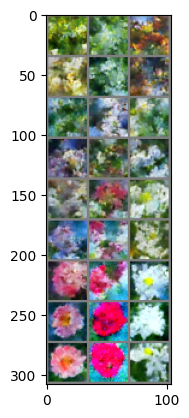

(tensor([[[[-5.3111e-02, -9.4241e-02, -1.9211e-01,  ..., -3.5313e-01,
            -5.5221e-01, -6.1791e-02],
           [-2.9440e-01, -2.8111e-01, -1.5048e-01,  ..., -4.7857e-01,
            -4.1533e-01,  3.7560e-02],
           [-3.4931e-01, -3.9607e-01, -2.9110e-01,  ..., -3.8931e-01,
            -2.7122e-02,  1.4042e-01],
           ...,
           [ 1.3291e-01,  1.9885e-01,  2.3147e-01,  ...,  3.8406e-01,
             3.5739e-01,  1.6137e-01],
           [-1.2983e-01, -1.6434e-01, -2.9133e-01,  ...,  1.9595e-01,
             7.7385e-02, -6.0814e-02],
           [ 3.8827e-01,  1.4367e-01, -4.6208e-02,  ..., -3.5004e-02,
            -1.9602e-01, -3.2463e-01]],
 
          [[-9.1174e-02, -9.2459e-02, -1.5052e-01,  ..., -1.5634e-01,
            -1.3120e-01,  1.2107e-02],
           [-2.9243e-01, -1.7883e-01,  2.3250e-01,  ...,  5.1063e-02,
             7.9750e-02,  1.8648e-01],
           [-1.8288e-01, -1.0056e-01,  1.1342e-01,  ...,  1.0075e-01,
             3.3567e-01,  4.2623e-01],


In [8]:
sample_flowers(text_prompts, w=[-2.5, -2.0, -1.0, -0.5, 0.0, 0.5, 1.0, 2.0, 2.5])

Looking at the generated images it seems that a weight around 2.0 produces the best images. Therefore I will set w=2.0 for the rest of the assignment.

In [9]:
w = [2.0]

### Promts

As the dataset only contains roses, daisies and sunflowers, I focus on these three types of flowers in all Prompts.

In [10]:
text_prompts = [
    "A photo of a flower",    
    "A picture of a flower",
    "A flower",
    "flower",
    
    "A photo of a red rose",
    "A picture of a red rose",
    "A photo of a rose",
    "A picture of a rose",
    "A rose",
    "rose",
    
    "A photo of a white daisy",  
    "A picture of a white daisy",
    "A photo of a daisy",
    "A picture of a daisy",
    "A daisy",
    "daisy",
    
    "A photo of a yellow sunflower",
    "A picture of a yellow sunflower",
    "A photo of a sunflower",
    "A picture of a sunflower",
    "A sunflower",
    "sunflower",
]

### Hook
A pytorch hook is added at down2 to extract feature maps during the sampling process.

In [11]:
# --- Embedding Extraction using Hooks ---
# We will use PyTorch hooks to extract the output of the 'down2' layer (the bottleneck).
embeddings_storage = {}
def get_embedding_hook(name):
    def hook(model, input, output):
        embeddings_storage[name] = output.detach()
    return hook
# Register a forward hook on the `down2` layer of the U-Net model.
# The hook should store the output of the layer in the `embeddings_storage` dictionary.
model.down2.register_forward_hook(get_embedding_hook('down2'))

Extracting the embeddings will look like this:

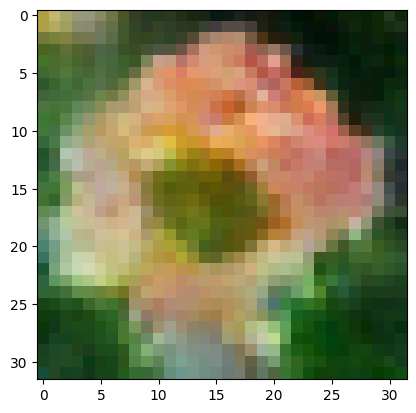

Extracted Embedding Shape: torch.Size([2, 512, 8, 8])


In [12]:
sample_flowers(text_prompts[:1], w=w)
extracted_embeddings = embeddings_storage['down2']
print("Extracted Embedding Shape:", extracted_embeddings.shape)

As we double the batch during generation, we get 2 indentical embeddings for each prompt.

In [13]:
print(torch.equal(extracted_embeddings[0], extracted_embeddings[1]))

True


We therefore change the embedding hook, to only give us one embedding

In [14]:
def get_embedding_hook(name):
    def hook(model, input, output):
        embeddings_storage[name] = output.detach()[0]
    return hook
model.down2.register_forward_hook(get_embedding_hook('down2'))

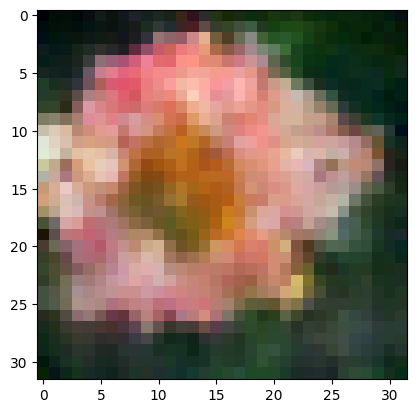

Extracted Embedding Shape: torch.Size([512, 8, 8])


In [15]:
sample_flowers(text_prompts[:1], w=w)
extracted_embeddings = embeddings_storage['down2']
print("Extracted Embedding Shape:", extracted_embeddings.shape)

### Generating Images

gen_flower is a modified version of sample_flowers, that generates only one image for a given prompt and returns the generated image as PIL image and the extracted embedding at down2.

In [16]:
def gen_flower(text, w=None) -> tuple[torch.Tensor, Image.Image, torch.Tensor]:
    text_tokens = clip_tokenizer([text]).to(device)
    c = clip_model.encode_text(text_tokens).float()
    x_gen, _ = ddpm_utils.sample_w(model, ddpm, INPUT_SIZE, T, c, device, w_tests=w)
    embedding = embeddings_storage['down2']
    img = other_utils.to_image(x_gen[0])
    grid = make_grid(x_gen.cpu(), nrow=len([text]))
    plt.title(f"Generated Image for Prompt: '{text}'")
    other_utils.show_tensor_image([grid])
    plt.show()
    return x_gen, img, embedding

The images are generated one by one to be able to extract the embeddings for each prompt separately.

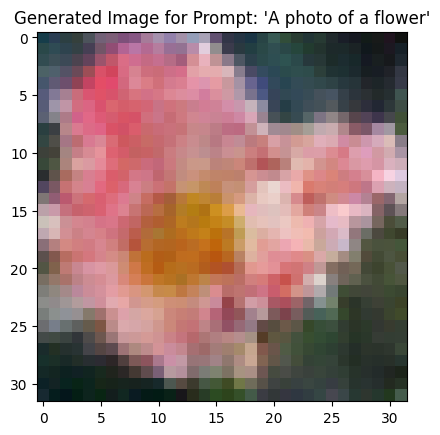

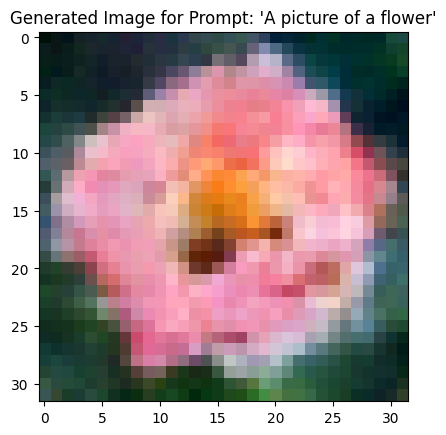

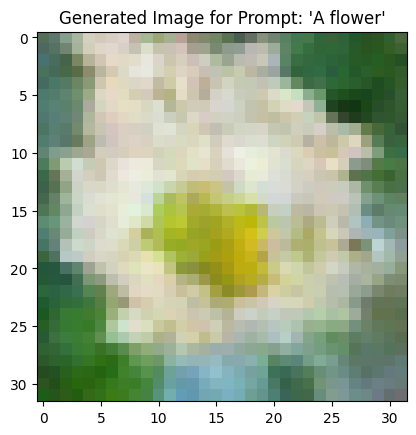

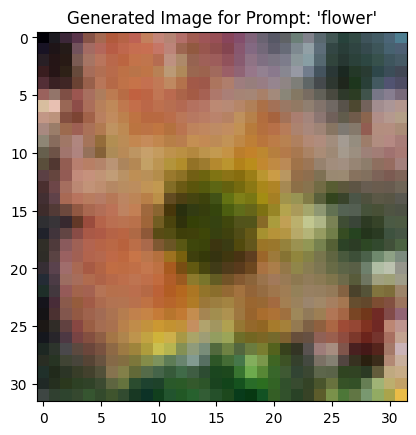

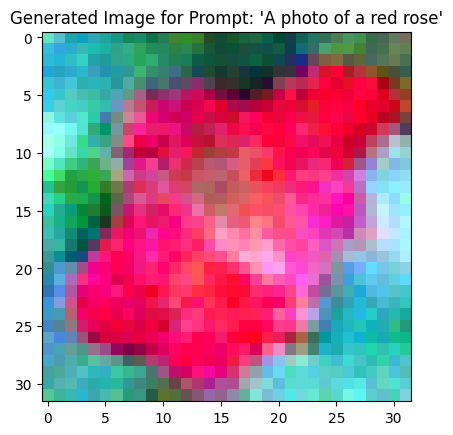

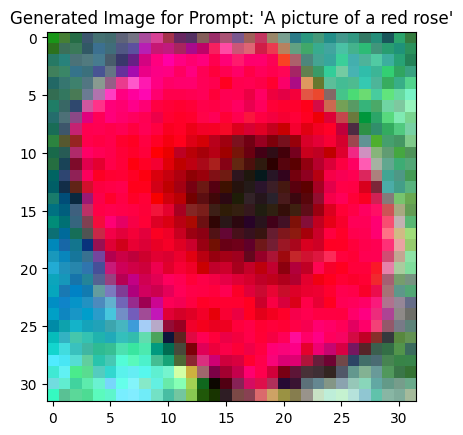

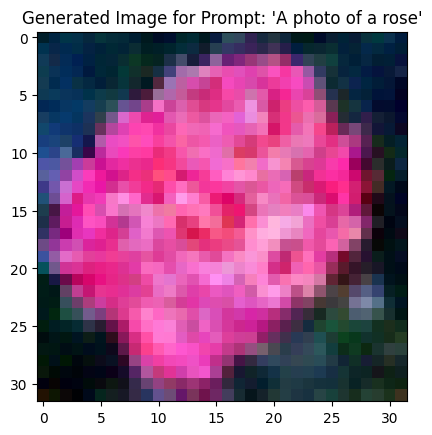

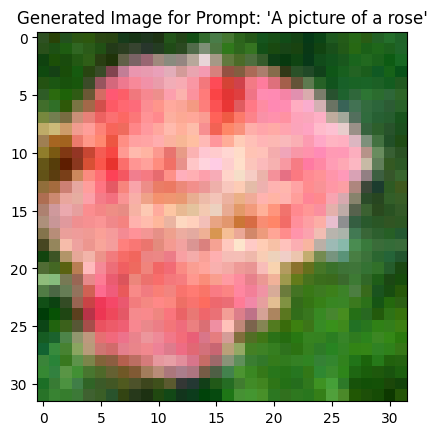

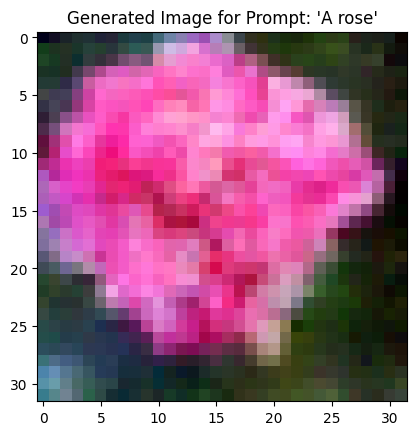

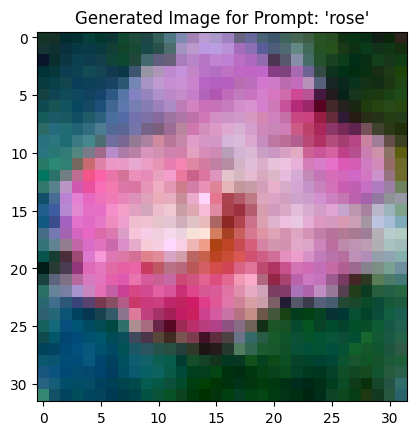

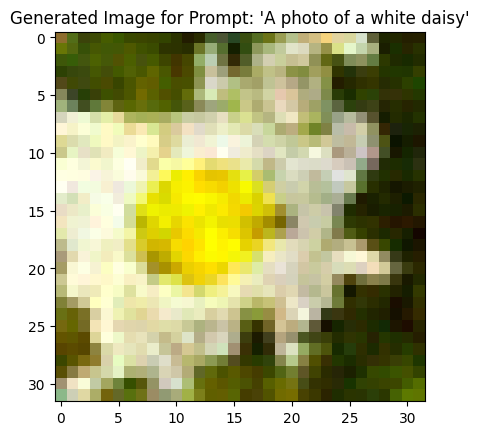

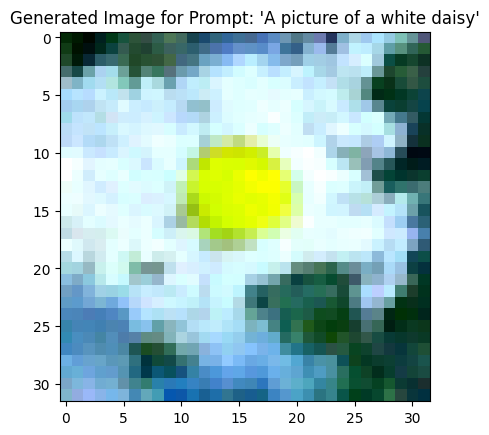

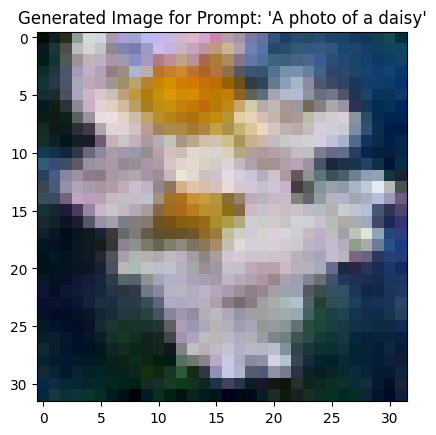

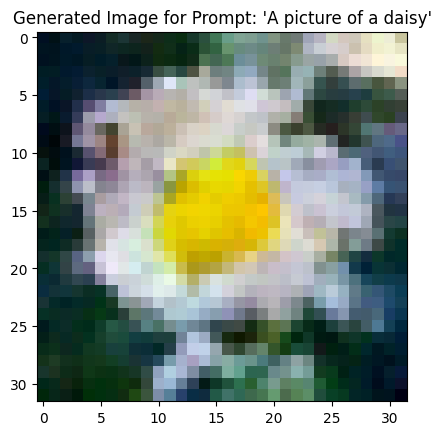

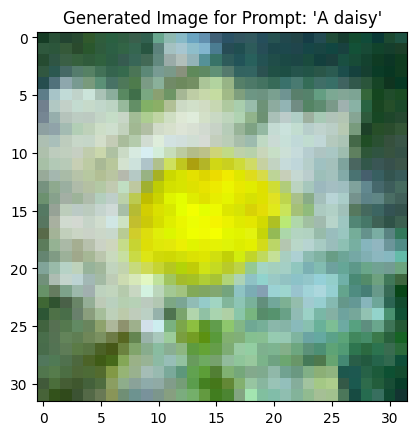

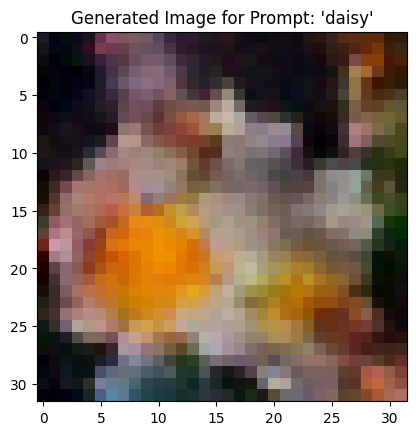

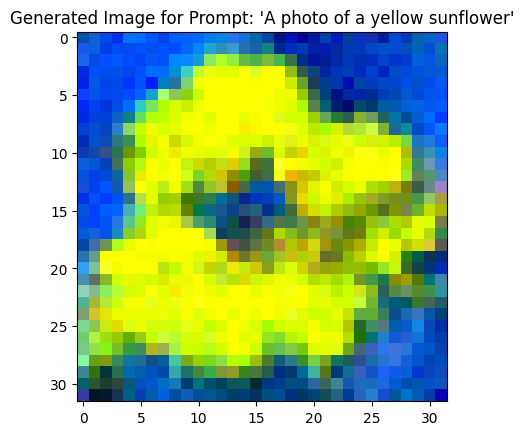

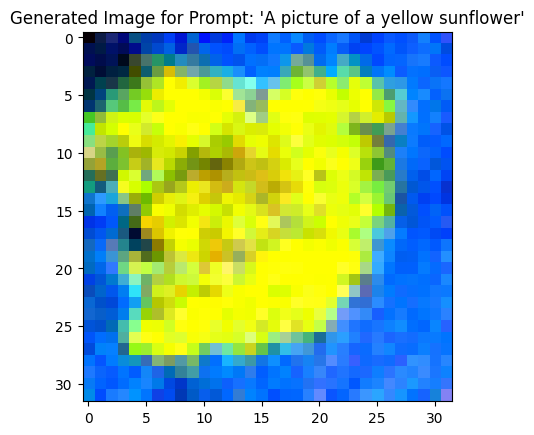

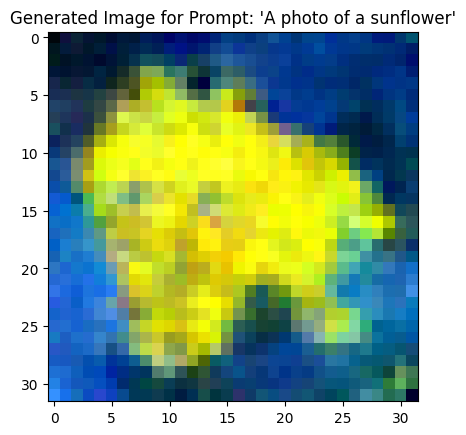

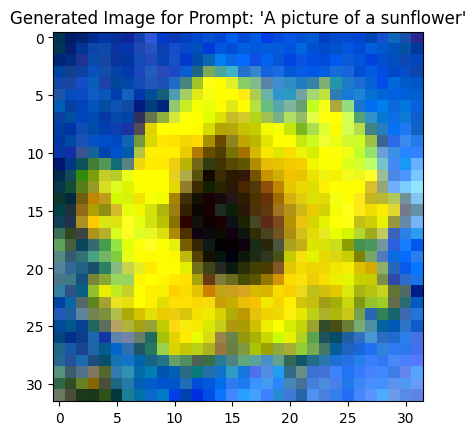

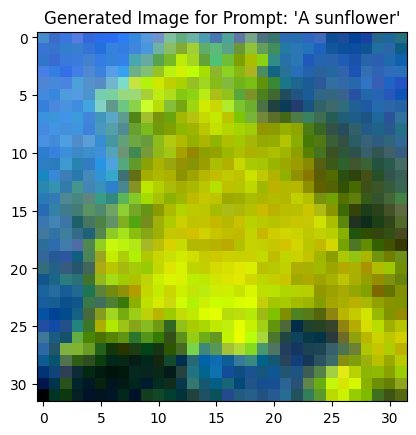

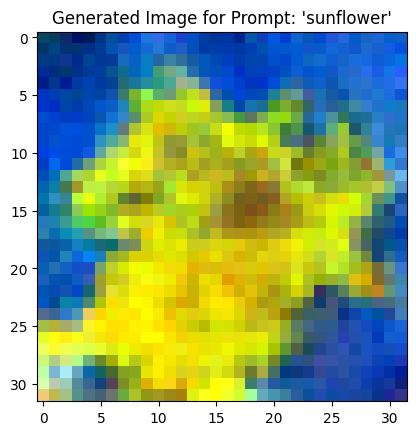

In [17]:
images = []
embeddings = []
paths = []
for prompt in text_prompts:
    _, img, embedding = gen_flower(prompt, w=w)
    image_path = f"generated_images/generated_{prompt.replace(' ', '_')}.png"
    img.save(image_path)
    images.append(img)
    embeddings.append(embedding)
    paths.append(image_path)
    

# Part 2

## Clip Score Evaluation

### Function Definition

The clip score is calculated with the function from the task description.

In [18]:
def calculate_clip_score(image_path, text_prompt):
    model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained='laion2b_s34b_b79k')
    image = preprocess(Image.open(image_path)).unsqueeze(0)
    tokenizer = open_clip.get_tokenizer('ViT-B-32')
    text = tokenizer([text_prompt])
    with torch.no_grad():
        image_features = model.encode_image(image)
        text_features = model.encode_text(text)
        image_features /= image_features.norm(dim=-1, keepdim=True)
        text_features /= text_features.norm(dim=-1, keepdim=True)
        score = (image_features @ text_features.T).item()
    return score

### Calculating Clip Scores

In [19]:
clip_scores = []
for path, prompt in zip(paths, text_prompts):
    score = calculate_clip_score(path, prompt)
    clip_scores.append(score)
    print(f"Clip Score for prompt '{prompt}': {score}")

Clip Score for prompt 'A photo of a flower': 0.2917957901954651
Clip Score for prompt 'A picture of a flower': 0.29533934593200684
Clip Score for prompt 'A flower': 0.27675724029541016
Clip Score for prompt 'flower': 0.2797973155975342
Clip Score for prompt 'A photo of a red rose': 0.24186824262142181
Clip Score for prompt 'A picture of a red rose': 0.25435489416122437
Clip Score for prompt 'A photo of a rose': 0.2894987463951111
Clip Score for prompt 'A picture of a rose': 0.2877327799797058
Clip Score for prompt 'A rose': 0.2796448767185211
Clip Score for prompt 'rose': 0.26704272627830505
Clip Score for prompt 'A photo of a white daisy': 0.28264114260673523
Clip Score for prompt 'A picture of a white daisy': 0.28922346234321594
Clip Score for prompt 'A photo of a daisy': 0.21851846575737
Clip Score for prompt 'A picture of a daisy': 0.2710685133934021
Clip Score for prompt 'A daisy': 0.2818093001842499
Clip Score for prompt 'daisy': 0.23456813395023346
Clip Score for prompt 'A photo

## FID Score Evaluation

### Function Definition

The fid score function is defined as in the task description.

In [20]:
def calculate_fid(real_embeddings, gen_embeddings):
    mu1, sigma1 = real_embeddings.mean(axis=0), np.cov(real_embeddings,
                                                       rowvar=False)
    mu2, sigma2 = gen_embeddings.mean(axis=0), np.cov(gen_embeddings, rowvar=False)
    ssdiff = np.sum((mu1 - mu2)**2)
    covmean = sqrtm(sigma1.dot(sigma2))
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)

    return fid

I also need the inception model to extract the embeddings from the real and generated images. I use the pretrained inception model from torchvision.

In [21]:
inception_preprocess = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

inception = inception_v3(weights=Inception_V3_Weights.DEFAULT).to(device)
inception.fc = nn.Identity()  # Replace classifier with passthrough
inception.eval()

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

I also define a function to extract the inception embeddings from a list of images.

In [22]:
def get_inception_embeddings(paths, batch_size=32):
    embeddings = np.array([])
    for i in range(0, len(paths), batch_size):
        batch_paths = paths[i:i+batch_size]
        imgs = []
        for path in batch_paths:
            img = Image.open(path).convert('RGB')
            img = inception_preprocess(img).unsqueeze(0)  # Add batch dimension
            imgs.append(img)
        imgs = torch.cat(imgs, dim=0).to(device)
        with torch.no_grad():
            batch_embeddings = inception(imgs)
            embeddings = np.concatenate((embeddings, batch_embeddings.cpu().numpy()), axis=0) if embeddings.size else batch_embeddings.cpu().numpy()
    return embeddings

### Calculating FID Score

Caluclating the inception embeddings for the generated images

In [23]:
inception_embeddings = get_inception_embeddings(paths, batch_size=16)
print("Inception Embeddings Shape:", inception_embeddings.shape)

Inception Embeddings Shape: (22, 2048)


Caluclating the inception embeddings for the real images

In [24]:
real_image_paths = []
dataset_path = "./data/cropped_flowers/"
# Iterate through subdirectories and collect image paths
for subdir in os.listdir(dataset_path):
    subdir_path = os.path.join(dataset_path, subdir)
    if os.path.isdir(subdir_path):
        for filename in os.listdir(subdir_path):
            if filename.endswith(('.png', '.jpg', '.jpeg')):
                real_image_paths.append(os.path.join(subdir_path, filename))
                
# Calculate inception embeddings for real images
real_image_inception_embeddings = get_inception_embeddings(real_image_paths, batch_size=16)
print("Real Image Inception Embeddings Shape:", real_image_inception_embeddings.shape)

Real Image Inception Embeddings Shape: (1166, 2048)


Calculating the FID Score between the real and generated images

In [25]:
fid_score_prompted_images = calculate_fid(
    real_image_inception_embeddings,
    inception_embeddings
)
print(f"FID Score between real and generated images: {fid_score_prompted_images}")

FID Score between real and generated images: 342.4012601273772


The FID score is high, which is expected for the small amount of images in the real dataset aswell as the really small amount of generated images.

Therefore the metric is not very meaningful in this case.

# Part 3

### Create FiftyOne Dataset and Calculate Insights

I now generate a FiftyOne dataset and analyze the images with FiftyOne

In [26]:
dataset = fo.Dataset(name="generated_flowers_with_embeddings", overwrite=True)
# Iterate through the generated images and add them to the dataset.
for path, prompt, clip_score, embedding in zip(paths, text_prompts, clip_scores, embeddings):
    # embedding is of shape torch.Size([512, 8, 8]) -> needs to be converted to np and should be of shape [512*8*8]
    unet_embedding = embedding.cpu().numpy().reshape(512*8*8)
    sample = fo.Sample(
        filepath=path,
        label=fo.Classification(label=prompt),
        clip_score=clip_score,
        unet_embedding=unet_embedding
    )
    dataset.add_sample(sample)
    
# Launch the FiftyOne App to visualize your dataset and analyze the results.
session = fo.launch_app(dataset, auto=False)

# Compute uniqueness for the dataset.

fob.compute_uniqueness(dataset)

# Compute representativeness using the extracted U-Net embeddings.

fob.compute_representativeness(dataset, embeddings="unet_embedding")

fob.compute_visualization(dataset, embeddings="unet_embedding", method="pca", brain_key="unet_pca", num_dims=2, seed=51)

# Refresh the session to see the computed fields in the FiftyOne App.
session.refresh()
print(session.url)

You are running the oldest supported major version of MongoDB. Please refer to https://deprecation.voxel51.com for deprecation notices. You can suppress this exception by setting your `database_validation` config parameter to `False`. See https://docs.voxel51.com/user_guide/config.html#configuring-a-mongodb-connection for more information


Session launched. Run `session.show()` to open the App in a cell output.


INFO:fiftyone.core.session.session:Session launched. Run `session.show()` to open the App in a cell output.


Computing embeddings...


INFO:fiftyone.brain.internal.core.utils:Computing embeddings...


 100% |███████████████████| 22/22 [1.7s elapsed, 0s remaining, 13.4 samples/s]      


INFO:eta.core.utils: 100% |███████████████████| 22/22 [1.7s elapsed, 0s remaining, 13.4 samples/s]      


Computing uniqueness...


INFO:fiftyone.brain.internal.core.uniqueness:Computing uniqueness...


Uniqueness computation complete


INFO:fiftyone.brain.internal.core.uniqueness:Uniqueness computation complete


Computing representativeness...


INFO:fiftyone.brain.internal.core.representativeness:Computing representativeness...


Computing clusters for 22 embeddings; this may take awhile...


INFO:fiftyone.brain.internal.core.representativeness:Computing clusters for 22 embeddings; this may take awhile...


Representativeness computation complete


INFO:fiftyone.brain.internal.core.representativeness:Representativeness computation complete


Generating visualization...


INFO:fiftyone.brain.visualization:Generating visualization...


http://localhost:5151/


... and publish the dataset to huggingface

In [27]:
hf_dataset_name = "generated-flowers-cv-assignment3-joscha"
push_to_hub(dataset, hf_dataset_name, exist_ok=True, token=os.getenv("HF_TOKEN"))

Directory '/tmp/tmph1lu1wog' already exists; export will be merged with existing files


Exporting samples...


INFO:fiftyone.utils.data.exporters:Exporting samples...


 100% |██████████████████████| 22/22 [55.2ms elapsed, 0s remaining, 398.5 docs/s] 


INFO:eta.core.utils: 100% |██████████████████████| 22/22 [55.2ms elapsed, 0s remaining, 398.5 docs/s] 
Uploading media files: 100%|██████████| 1/1 [00:05<00:00,  5.59s/it]


### FiftyOne Discussion

#### General Insights
Looking at FiftyOne we see:
![FiftyOne Overview](./screenshots/ds_overview.png)

When we then click on a Sample we get more insight, seeing the CLIP score, uniqueness and representativeness scores:
![FiftyOne Sample](./screenshots/sample_view.png)

We can see Clip Scores around 0.2-0.3 for the images and almost equally distributed uniqueness. The representativeness is for almost all image excatly 1.0

#### PCA
It gets more interesting when we look at the PCA view of the dataset:
![FiftyOne PCA](./screenshots/pca.png)

Here we can see clustering for the different flower types, even though we have low samples. This shows that the embeddings extracted at down2 contain meaningful information about the image content.
For example those connected dots are all daisies:
![FiftyOne PCA Daisies](./screenshots/pca_cluster.png)

And when we select samples from one class, we see that all embeddings are close together:
![FiftyOne PCA Selected](./screenshots/pca_classes.png)

# Part 4

Finally all results are logged to wandb

In [28]:

# Login to wandb.

wandb.login(key=os.getenv("WANDB_KEY"))

# Initialize a new wandb run and log your hyperparameters (e.g., guidance weight `w`, number of steps `T`).
config = {
    "guidance_weight": w,
    "num_steps": T,
    "image_size": IMG_SIZE,
    "model": "DDPM with CLIP guidance",
    "dataset": "Flowers"
}
run = wandb.init(entity="joscha-schroff", project="diffusion_model_assessment_v2", config=config)


# Log your evaluation metrics (CLIP Score and FID).
avg_clip_score = sum(clip_scores) / len(clip_scores)
wandb.log({
    "clip_score": avg_clip_score,
    "fid_score": fid_score_prompted_images
})

table_data = []
for path, prompt, clip_score in zip(paths, text_prompts, clip_scores):
    sample = dataset[os.path.join(os.getcwd(), path)]
    uniqueness_score = sample.uniqueness
    representativeness_score = sample.representativeness
    table_data.append([
        wandb.Image(path),
        prompt,
        clip_score,
        uniqueness_score,
        representativeness_score
    ])
results_table = wandb.Table(
    columns=["Generated Image", "Text Prompt", "CLIP Score", "Uniqueness Score", "Representativeness Score"],
    data=table_data
)
wandb.log({"results_table": results_table})
    
# Finish the wandb run.
run.finish()

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/joscha/.netrc
wandb: Currently logged in as: joscha-schroff to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


clip_score,▁
fid_score,▁
clip_score,0.25972
fid_score,342.40126
